In [1]:
import numpy as np
import numpy.linalg as nla
import numpy.random as nrd

import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import mode
from scipy.linalg import norm

from scipy.interpolate import BSpline
from sklearn.cluster import KMeans

import warnings

# Exercise 12.5

The data in phoneme.subset, available from this book’s website
http://www-stat.stanford.edu/ElemStatLearn
consists of digitized log-periodograms for phonemes uttered by 60 speakers,
each speaker having produced phonemes from each of five classes. It is
appropriate to plot each vector of 256 “features” against the frequencies
0–255.

(a) Produce a separate plot of all the phoneme curves against frequency
for each class.

(b) You plan to use a nearest prototype classification scheme to classify
the curves into phoneme classes. In particular, you will use a K-means
clustering algorithm in each class (kmeans() in R), and then classify
observations to the class of the closest cluster center. The curves are
high-dimensional and you have a rather small sample-size-to-variables
ratio. You decide to restrict all the prototypes to be smooth functions
of frequency. In particular, you decide to represent each prototype m
as m = Bθ where B is a 256 × J matrix of natural spline basis
functions with J knots uniformly chosen in (0, 255) and boundary
knots at 0 and 255. Describe how to proceed analytically, and in
particular, how to avoid costly high-dimensional fitting procedures.
(Hint: It may help to restrict B to be orthogonal.)

(c) Implement your procedure on the phoneme data, and try it out. Divide
the data into a training set and a test set (50-50), making sure that
speakers are not split across sets (why?). Use K = 1, 3, 5, 7 centers
per class, and for each use J = 5, 10, 15 knots (taking care to start
the K-means procedure at the same starting values for each value of
J), and compare the results.

# Solution

Useful functions for the notebook,

In [2]:
# Generate J internal nodes plus boundary nodes for B-spline of degree k
def bspline_knots(J,k,freq_range):
    
    knot_in, knot_fin = freq_range
    delta = (knot_fin - knot_in - 1)/(J+1) # uniform space between internal knots
    
    knots = [int(delta*(i+1)) for i in range(J)]
    M = (k+1)//2
    
    return [knot_in]*M + knots + [knot_fin-1]*M

# Create matrix those columns are elements of orthonormal basis
# for a B-spline of order k and J internal nodes.
def basis_bspline_orthonormal(J,k,freq_range):

    # We create the knowts for the B-spline (internal and boundary ones)
    frequencies = np.arange(*freq_range,1)
    knots = bspline_knots(J,k,freq_range)

    # We generate the B-spline basis, and we plot it
    B = []
    for i in range(J):
        coeffs = np.zeros(p)
        coeffs[i] = 1
        b = BSpline(knots,coeffs,k)
        B.append(b(frequencies))

    # Here we orthonormalize the matrix whose columns are the basis function
    # NOTICE, we orthonormalize it in the given range of frequency.
    B = np.array(B).T
    B_orth,_ = nla.qr(B)

    return B_orth

# Use K-means clustering to find K centroid per phoneme
def get_centroids_for_phenome(X,y,phenome,K,seed=0):
    
    _,J = X.shape
    centroids = np.empty((0,J),dtype=np.float)
    
    for ph in phenome:
        # Select a specific class for training
        bool_ph = y_train == ph
        X_ph = X[bool_ph]

        # Train the K-means clustering and get centroids for the class
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            model = KMeans(K,n_init=30,random_state=seed)
            model.fit(X_ph)

        # Add the class centroids to the list of all centrids
        centroids = np.vstack((centroids,model.cluster_centers_))
        
    return centroids

# Given the list of centroids and phonemes, predict the class for X
def predict_phoneme(X,phenome,centroids,K):
    
    N,_ = X.shape

    # Compute distance from centroids
    distance = np.empty((0,N),dtype=np.float)
    for m in centroids:
        dist_m = np.sum((X-m)**2,axis=1) # I would use nla.norm but it raises exception!
        distance = np.vstack((distance,dist_m))

    # Predict the class/phoneme
    class_predict = np.argmin(distance,axis=0)//K
    y_predict = np.empty(N,np.dtype('U25'))
    for k,ph in enumerate(phenome):
        bool_k = class_predict == k
        y_predict[bool_k] = ph

    return y_predict

# Compute misclassification error for K-mean clustering
def test_error_clustering(y,y_predict):
    return np.mean(y_predict != y)

Get the data,

In [3]:
url_link = 'https://web.stanford.edu/~hastie/ElemStatLearn/datasets/phoneme.data'
dataframe = pd.read_csv(url_link,index_col='row.names')

dataframe.tail()

,x.1,x.2,x.3,x.4,x.5,x.6,x.7,x.8,x.9,x.10,...,x.249,x.250,x.251,x.252,x.253,x.254,x.255,x.256,g,speaker
row.names,,,,,,,,,,,,,,,,,,,,,
4505,11.38394,10.21040,16.32658,18.30125,16.91804,10.90029,17.10393,19.37741,18.46994,14.12358,...,9.79996,7.85765,6.92906,8.89384,8.04072,6.99793,6.07412,7.32593,iy,test.dr8.mslb0.sa1
4506,12.01774,11.86761,16.34707,18.05214,15.97599,12.86022,16.83436,18.38985,15.90410,13.18483,...,8.20094,8.40645,7.49869,9.56486,10.86934,8.85308,9.88492,6.35767,aa,test.dr8.mslb0.sa1
4507,12.30174,12.40383,9.06497,12.43750,13.48388,13.52034,12.97796,11.58782,12.54174,14.09863,...,12.83836,10.62525,10.15274,9.59347,10.66338,9.88007,10.82203,12.00199,sh,test.dr8.mslb0.sa1
4508,8.39388,9.84770,16.24534,17.35311,14.80537,12.72429,17.01145,17.54733,14.35809,13.65718,...,4.57875,7.91262,8.08014,9.25111,9.56086,9.37979,6.83916,8.54817,ao,test.dr8.mslb0.sa1
4509,8.14032,9.93753,16.30187,17.31425,14.40116,13.52353,16.85938,17.14016,13.06426,15.32220,...,5.27574,6.95050,7.83462,7.96455,7.26886,7.08945,7.72929,6.42167,ao,test.dr8.mslb0.sa1


### Phenome

Here we visualize the different phenome, so that the different feature in fequency are visible,

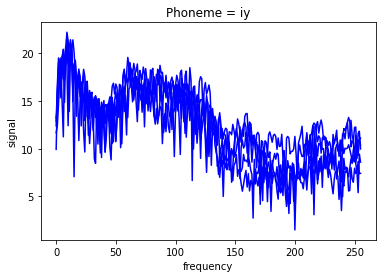

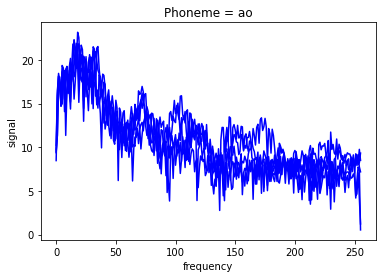

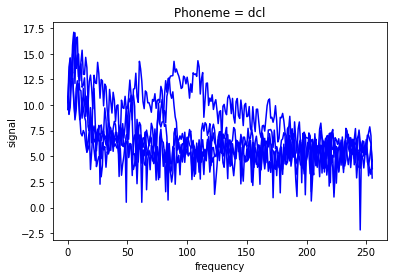

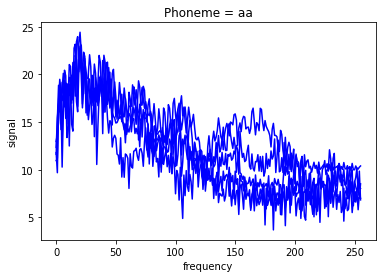

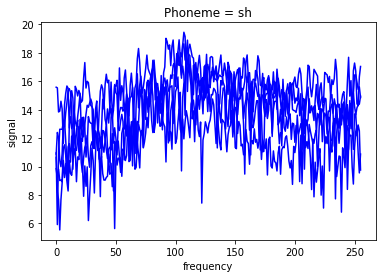

In [4]:
phenome = set(dataframe['g'])

frequencies = np.arange(0,256,1)
sample = 5

for ph in phenome:
    bool_ph = dataframe['g'] == ph
    X = dataframe[bool_ph].to_numpy()
    X = X[:,:-2]
    
    for x in X[:sample]:
        plt.plot(frequencies,x,c='b')
        
    plt.title('Phoneme = {}'.format(ph))
    plt.xlabel('frequency')
    plt.ylabel('signal')
    plt.show()

### Orthonormal basis function for cubic spline

Here we use B-spline, that we orthonormalize over the range of frequencies to simplify the transformation of the original features into a smaller feature space.

Example with J = 10 knots, we show the basis of B-splines of order k = 3 and the orthonormalize basis,

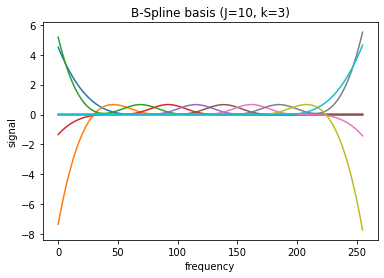

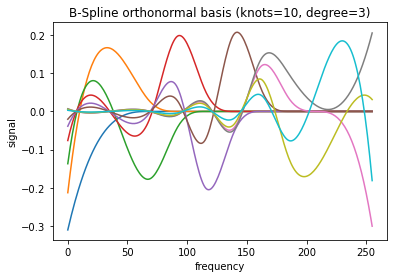

In [5]:
# Number of knots
J = 10
k = 3
p = 256
freq_range = [0,p]

# We create the knowts for the B-spline (internal and boundary ones)
frequencies = np.arange(*freq_range,1)
knots = bspline_knots(J,k,freq_range)

# We generate the B-spline basis, and we plot it
B = []
for i in range(J):
    coeffs = np.zeros(p)
    coeffs[i] = 1
    b = BSpline(knots,coeffs,k)
    B.append(b(frequencies))
    plt.plot(frequencies,b(frequencies))

plt.title('B-Spline basis (J={}, k={})'.format(J,k))
plt.xlabel('frequency')
plt.ylabel('signal')
plt.show()

# Here we orthonormalize the matrix whose columns are the basis function
# NOTICE, we orthonormalize it in the given range of frequency.
B = np.array(B).T
B_orth,_ = nla.qr(B)

for j in range(J):
    b_orth = B_orth[:,j]
    plt.plot(frequencies,b_orth)
    
plt.title('B-Spline orthonormal basis (knots={}, degree={})'.format(J,k))
plt.xlabel('frequency')
plt.ylabel('signal')
plt.show()

### Feature transformation and K-means

First let us split the data in training and test,

In [6]:
speakers = dataframe['speaker'].unique()
n = speakers.size

# select the speakers to use for the training
rng = nrd.default_rng(seed=140590)
train_speakers = rng.choice(speakers,n//2,replace=False)
bool_train = dataframe['speaker'].isin(train_speakers)

# Training set
X_train = dataframe[bool_train].to_numpy()
y_train = X_train[:,-2]
X_train = X_train[:,:-2]

# Test set
X_test = dataframe[~bool_train].to_numpy()
y_test = X_test[:,-2]
X_test = X_test[:,:-2]

Let us transform the input features and use K-mean centering,

In [7]:
# List of number of clusters per phoneme
K_list = [1,3,5,7]

# List of number of internal nodes for spline
J_list = [5,10,15]

test_error = {}
for J in J_list:
    
    # Produce matrix of orthonormal basis splines and project X_train and X_label
    B = basis_bspline_orthonormal(J,k,freq_range)
    X1_train = X_train @ B
    X1_test = X_test @ B
    
    for K in K_list:
        
        # Get the centroid list, K centroids for each phoneme
        centroids = get_centroids_for_phenome(X1_train,y_train,phenome,K)
        
        # Predict the test label using the centroids
        y_test_predict = predict_phoneme(X1_test,phenome,centroids,K)
        
        # Compute misclassification error
        err = test_error_clustering(y_test,y_test_predict)
        print('K = {} clusters per phoneme, prototypes smoothed with cubic spline of J = {} nodes'.format(K,J))
        print('Test error = {:.3f}'.format(err))
    print('---')

K = 1 clusters per phoneme, prototypes smoothed with cubic spline of J = 5 nodes
Test error = 0.188
K = 3 clusters per phoneme, prototypes smoothed with cubic spline of J = 5 nodes
Test error = 0.153
K = 5 clusters per phoneme, prototypes smoothed with cubic spline of J = 5 nodes
Test error = 0.152
K = 7 clusters per phoneme, prototypes smoothed with cubic spline of J = 5 nodes
Test error = 0.153
---
K = 1 clusters per phoneme, prototypes smoothed with cubic spline of J = 10 nodes
Test error = 0.145
K = 3 clusters per phoneme, prototypes smoothed with cubic spline of J = 10 nodes
Test error = 0.121
K = 5 clusters per phoneme, prototypes smoothed with cubic spline of J = 10 nodes
Test error = 0.119
K = 7 clusters per phoneme, prototypes smoothed with cubic spline of J = 10 nodes
Test error = 0.121
---
K = 1 clusters per phoneme, prototypes smoothed with cubic spline of J = 15 nodes
Test error = 0.137
K = 3 clusters per phoneme, prototypes smoothed with cubic spline of J = 15 nodes
Test 

Let's take a single cluster per phoneme and plot the centroid wogether with some input data,

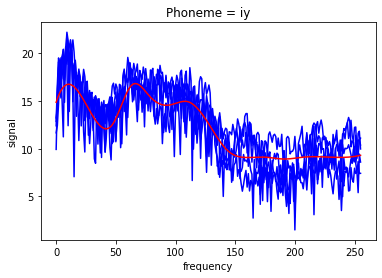

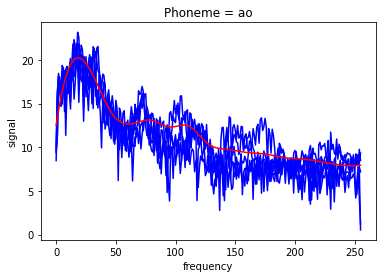

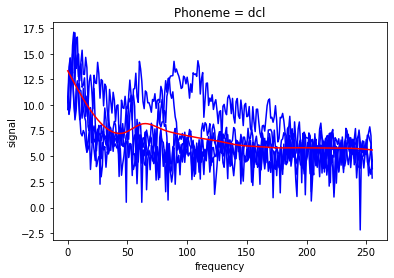

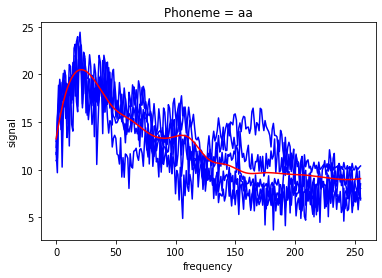

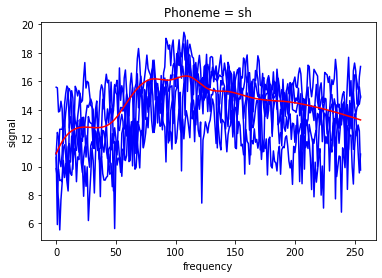

In [8]:
J = 15
K = 1

B = basis_bspline_orthonormal(J,k,freq_range)
X1_train = X_train @ B

# Get the centroids and map them back to the original space
centroids = get_centroids_for_phenome(X1_train,y_train,phenome,K)
centroids = centroids @ B.T

for ph,m in zip(phenome,centroids):
    bool_ph = dataframe['g'] == ph
    X = dataframe[bool_ph].to_numpy()
    X = X[:,:-2]
    
    for x in X[:sample]:
        plt.plot(frequencies,x,c='b')
        
    plt.plot(frequencies,m,c='r')
        
    plt.title('Phoneme = {}'.format(ph))
    plt.xlabel('frequency')
    plt.ylabel('signal')
    plt.show()